### Setup

This notebook explains how to to access the dataset models from django.
The datasets are loaded from the Postgres database into pandas dataframes.

To start the notebook server:

```
# Start a bash shell inside the api container
docker-compose exec api /bin/bash

# Start the jupyter notebook
python manage.py shell_plus --notebook

# Take note of the token provided and access the notebook through:
<ip-of-the-machine>:7777/?<token>
http://127.0.0.1:7777/?token=30c43675981e671b4a609cff470819098e274bbde415b7f5
```

This step has only to be made once as long as the jupyter-notebook keeps executing.
Considering that the the notebook continues to run, you can access the notebook using:
``` 
<ip-of-the-machine>:7777/?<token>
```

In [1]:
# Required to access the database
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Data analysis tools
import pandas as pd
import numpy as np
import seaborn as sns

# Models available in our application
from datasets.models import RawFlower, RawUNM, RawDAR
from django.contrib.auth.models import User

In [2]:
from api import adapters
from api import analysis

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:

CAT_NEU_ANALYTES = [('Analytes', (
    ('USB', 'Antimony - Urine'),
    ('UTAS', 'Arsenic Total - Urine'), #modified just for poster - change back later/check if it's actually total 
    ('UBA', 'Barium - Urine'),
    ('UBE', 'Beryllium - Urine'),
    ('UCD', 'Cadmium - Urine'),
    ('UCS', 'Cesium - Urine'),
    ('UCR', 'Chromium - Urine'),
    ('UCO', 'Cobalt - Urine'),
    ('UCU', 'Copper - Urine'),
    ('UPB', 'Lead - Urine'),
    ('UMN', 'Manganese - Urine'),
    ('UHG', 'Mercury - Urine'),
    ('UMO', 'Molybdenum - Urine'),
    ('UNI', 'Nickel - Urine'),
    ('UPT', 'Platinum - Urine'),
    ('USE', 'Selenium - Urine'),
    ('UTL', 'Thallium - Urine'),
    ('USN', 'Tin - Urine'),
    ('UTU', 'Tungsten - Urine'),
    ('UUR', 'Uranium - Urine'),
    ('UVA', 'Vanadium - Urine'),
    ('UZN', 'Zinc - Urine')
    # Blood
    # ('BSB', 'Antimony - Blood'   ),
    # ('BTAS','Arsenic - Blood'    ),
    # ('BAL', 'Aluminum - Blood'   ),
    # ('BBE', 'Beryllium - Blood'  ),
    # ('BBA', 'Barium - Blood'     ),
    # ('BCD', 'Cadmium - Blood'    ),
    # ('BCS', 'Cesium - Blood'     ),
    # ('BCO', 'Cobalt - Blood'     ),
    # ('BCU', 'Copper - Blood'     ),
    # ('BCR', 'Chromium - Blood'   ),
    # ('BFE', 'Iron - Blood'       ),
    # ('BPB', 'Lead - Blood'       ),
    # ('BPB208','Lead (208) - Blood'),
    # ('BMB', 'Manganese - Blood'  ),
    # ('BHG', 'Mercury - Blood'    ),
    # ('BMO', 'Molybdenum - Blood' ),
    # ('BNI', 'Nickel - Blood'     ),
    # ('BPT', 'Platinum - Blood'   ),
    # ('BTL', 'Thallium - Blood'   ),
    # ('BTU', 'Tungsten - Blood'   ),
    # ('BUR', 'Uranium - Blood'    ),
    # ('BVA', 'Vanadium - Blood'   ),
    # ('BSE', 'Selenium - Blood'),
    # ('BSEG1124', 'Selenium+G1124 - Blood'),
    # ('BSN', 'Tin - Blood'        ),
    # ('BZN', 'Zinc - Blood'       ),
))]


CAT_DAR_ANALYTES = [('Analytes', (
    # Analyate acronym and name,                    Mapping in the dar DB
    ('UAG', ' Silver - Urine'),                     # Ag in ug/L
    ('UAL', ' Aluminium - Urine'),                  # Al in ug/L
    ('UCR',  'Chromium - Urine'),                   # Cr in ug/L
    ('UCU',  'Copper - Urine'),                     # Cu in ug/L
    ('UFE',  'Iron - Urine'),                       # Fe in ug/L
    ('UNI',  'Niquel - Urine'),                     # Ni in ug/L
    ('UVA',  'Vanadium - Urine'),                   # V in ug/L
    ('UZN',  'Zinc - Urine'),                       # Zn in ug/L
    # ('BCD',  'Cadmium - Blood'),
    # ('BHGE', 'Ethyl Mercury - Blood'),
    # ('BHGM', 'Methyl Mercury - Blood'),
    # ('BMN',  'Manganese - Blood'),
    # ('BPB',  'Lead - Blood'),
    # ('BSE',  'Selenium - Blood'),
    # ('IHG',  'Inorganic Mercury - Blood'),
    # ('THG',  'Mercury Total - Blood'),
    # ('SCU',  'Copper - Serum'),
    # ('SSE',  'Selenium - Serum'),
    # ('SZN',  'Zinc - Serum'),
    ('UAS3', 'Arsenous (III) acid - Urine'),        # As in ug/L
    # ('UAS5', 'Arsenic (V) acid - Urine'),
    ('UASB', 'Arsenobetaine - Urine'),              # AsB in ug/L
    # ('UASC', 'Arsenocholine - Urine'),
    ('UBA',  'Barium - Urine'),                     # Ba in ug/L
    ('UBE',  'Beryllium - Urine'),                  # Be in ug/L
    ('UCD',  'Cadmium - Urine'),                    # Cd in ug/L
    ('UCO',  'Cobalt - Urine'),                     # Co in ug/L
    ('UCS',  'Cesium - Urine'),                     # Cs in ug/L
    ('UDMA', 'Dimethylarsinic Acid - Urine'),       # DMA in ug/L
    ('UHG',  'Mercury - Urine'),                    # Hg in ug/L
    # ('UIO',  'Iodine - Urine'),
    ('UMMA', 'Monomethylarsinic Acid - Urine'),     # MMA in ug/L
    ('UMN',  'Manganese - Urine'),                  # Mn in ug/L
    ('UMO',  'Molybdenum - Urine'),                 # Mo in ug/L
    ('UPB',  'Lead - Urine'),                       # PB in ug/L
    # ('UPT',  'Platinum - Urine'),
    ('USB',  'Antimony - Urine'),                   # Sb in ug/L
    ('USN',  'Tin - Urine'),                        # Sn in ug/L
    ('USR',  'Strontium - Urine'),                  # Sr in ug/L
    ('UTAS', 'Arsenic Total - Urine'),              # iAs in ug/L
    ('UTL',  'Thallium - Urine'),                   # Tl in ug/L
    # ('UTMO', 'Trimethylarsine - Urine')
    ('UTU',  'Tungsten - Urine'),                   # W in ug/L
    ('UUR',  'Uranium - Urine'),                    # U in ug/L

))]

CAT_UNM_ANALYTES = [('Analytes', (
    ('BCD',  'Cadmium - Blood'),
    ('BHGE', 'Ethyl Mercury - Blood'),
    ('BHGM', 'Methyl Mercury - Blood'),
    ('BMN',  'Manganese - Blood'),
    ('BPB',  'Lead - Blood'),
    ('BSE',  'Selenium - Blood'),
    ('IHG',  'Inorganic Mercury - Blood'),
    ('THG',  'Mercury Total - Blood'),
    ('SCU',  'Copper - Serum'),
    ('SSE',  'Selenium - Serum'),
    ('SZN',  'Zinc - Serum'),
    ('UAS3', 'Arsenous (III) acid - Urine'),
    ('UAS5', 'Arsenic (V) acid - Urine'),
    ('UASB', 'Arsenobetaine - Urine'),
    ('UASC', 'Arsenocholine - Urine'),
    ('UBA',  'Barium - Urine'),
    ('UBE',  'Beryllium - Urine'),
    ('UCD',  'Cadmium - Urine'),
    ('UCO',  'Cobalt - Urine'),
    ('UCS',  'Cesium - Urine'),
    ('UDMA', 'Dimethylarsinic Acid - Urine'),
    ('UHG',  'Mercury - Urine'),
    ('UIO',  'Iodine - Urine'),
    ('UMMA', 'Monomethylarsinic Acid - Urine'),
    ('UMN',  'Manganese - Urine'),
    ('UMO',  'Molybdenum - Urine'),
    ('UPB',  'Lead - Urine'),
    ('UPT',  'Platinum - Urine'),
    ('USB',  'Antimony - Urine'),
    ('USN',  'Tin - Urine'),
    ('USR',  'Strontium - Urine'),
    ('UTAS', 'Arsenic Total - Urine'),
    ('UTL',  'Thallium - Urine'),
    ('UTMO', 'Trimethylarsine - Urine'),
    ('UTU',  'Tungsten -  Urine'),
    ('UUR',  'Uranium - Urine'),

))]


In [4]:
from api import adapters
from api import analysis
import pandas as pd

df_neu = adapters.neu.get_dataframe_orig()  # [selected_columns]
df_unm = adapters.unm.get_dataframe_orig()  # [selected_columns]
df_dar = adapters.dar.get_dataframe()  # [selected_columns]

df_neu = df_neu.replace(-9, np.nan).replace('-9', np.nan)
df_unm = df_unm.replace(-9, np.nan).replace('-9', np.nan)
df_dar = df_dar.replace(-9, np.nan).replace('-9', np.nan)

unm = [x[0] for x in CAT_UNM_ANALYTES[0][1]]
neu = [x[0] for x in CAT_NEU_ANALYTES[0][1]]
dar = [x[0] for x in CAT_NEU_ANALYTES[0][1]]




(472, 32)
        id PIN_Patient Member_c TimePeriod Analyte     Result  \
0    39995           1        1          1    UTAS   1.031338   
1    39996           1        1          1     UPB   0.296959   
2    39997           2        1          1    UTAS   4.988018   
3    39998           2        1          1     UPB   0.853676   
4    39999           3        1          1    UTAS  14.891591   
..     ...         ...      ...        ...     ...        ...   
467  40462          75        1          1    UMMA   0.720000   
468  40463          76        1          1    UMMA   0.460000   
469  40464          77        1          1    UMMA   0.670000   
470  40465          78        1          1    UMMA   0.590000   
471  40466          79        1          1    UMMA   0.210000   

     Creat_Corr_Result  creatininemgdl Outcome  Outcome_weeks  ...  birthLen  \
0             1.289173            80.0       0      41.098400  ...    50.800   
1             0.371198            80.0       0   

In [5]:
def cohort_encode(cohort):
    if cohort == 'NEU':
        return 1
    if cohort == 'DAR':
        return 2
    if cohort == 'UNM':
        return 3

In [6]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from api import analysis
import matplotlib
import traceback

df1 = adapters.unm.get_dataframe_orig()  # [selected_columns]
df2 = adapters.neu.get_dataframe()  # [selected_columns]
df3 = adapters.neu.get_dataframe()  # [selected_columns]

df = analysis.merge3CohortFrames(df1, df2, df3)

(472, 32)
        id PIN_Patient Member_c TimePeriod Analyte     Result  \
0    39995           1        1          1    UTAS   1.031338   
1    39996           1        1          1     UPB   0.296959   
2    39997           2        1          1    UTAS   4.988018   
3    39998           2        1          1     UPB   0.853676   
4    39999           3        1          1    UTAS  14.891591   
..     ...         ...      ...        ...     ...        ...   
467  40462          75        1          1    UMMA   0.720000   
468  40463          76        1          1    UMMA   0.460000   
469  40464          77        1          1    UMMA   0.670000   
470  40465          78        1          1    UMMA   0.590000   
471  40466          79        1          1    UMMA   0.210000   

     Creat_Corr_Result  creatininemgdl Outcome  Outcome_weeks  ...  birthLen  \
0             1.289173            80.0       0      41.098400  ...    50.800   
1             0.371198            80.0       0   

<AxesSubplot:xlabel='UTAS', ylabel='birthLen'>

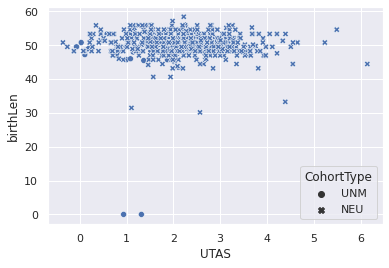

In [7]:
#data = fixvisits(data)


x_feature = 'UTAS'
y_feature = 'birthLen'
data = df
color_by = 'CohortType'
sns.set()

filtered_df = data[data[[x_feature, y_feature]].notnull().all(1)]

#take log transform
filtered_df[x_feature] = np.log(filtered_df[x_feature])
data[x_feature] = np.log(data[x_feature])

color_by_options = filtered_df[color_by].unique()

reg_info0 = ''
reg_info1 = ''

sns.scatterplot(data=filtered_df, x=x_feature,
                y=y_feature,  style=color_by)



In [8]:
import seaborn as sns
sns.__version__

'0.11.2'

In [9]:
def cohort_encode(cohort):
    if cohort == 'NEU':
        return 1
    if cohort == 'DAR':
        return 2
    if cohort == 'UNM':
        return 3


df['CohortType'] = df['CohortType'].apply(lambda x: cohort_encode(x))

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


['1', '3']


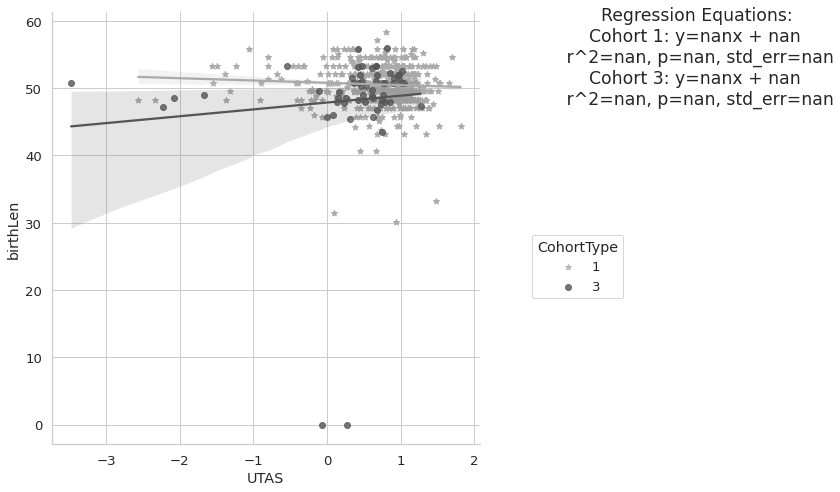

In [10]:
#data = fixvisits(data)


x_feature = 'UTAS'
y_feature = 'birthLen'
data = df
color_by = 'CohortType'
sns.set(style = 'whitegrid', font_scale = 1.2)


filtered_df = data[data[[x_feature, y_feature]].notnull().all(1)]

#take log transform
filtered_df[x_feature] = np.log(filtered_df[x_feature])
data[x_feature] = np.log(data[x_feature])

color_by_options = filtered_df[color_by].unique()

reg_info0 = ''
reg_info1 = ''


gr = sns.lmplot(data=filtered_df, x=x_feature, markers=['*', 'o'],
                y=y_feature, hue=color_by,
                legend_out=False, 
                height=7, aspect=1,
                palette='binary')

#TODO fix legends - not the best way to display equations

labs = list(gr._legend_data.keys())
labs2 = []

for x in labs:

    try:
        x2 = float(x)
    except:
        x2 = x
    labs2.append(x2)

print(labs)
# for x in xrange(len(color_by_options)):
# adding support if we want to color by multiple options 

num_lines = len(gr.axes.flat[0].get_lines())

reg_infos = ['Regression Equations:\n']

if (num_lines > 1):

    for i in range(0, num_lines):
        try:

            x = filtered_df.loc[filtered_df[color_by] == labs2[i], x_feature].values
            y = filtered_df.loc[filtered_df[color_by] == labs2[i], y_feature].values

            # this is problematic for calcuatign the true stats
            # = [gr.axes.flat[0].get_lines()[i].get_xdata()]
            #y = [gr.axes.flat[0].get_lines()[i].get_ydata()]

            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

            reg_info1 = 'Cohort ' + str(labs[i]) + ": y={:.2f}x + {:.2f} \n r^2={:.2f}, p={:.2f}, std_err={:.2f}\n".format(
            slope, intercept, r_value**2, p_value, std_err)

            reg_infos.append(reg_info1)

        except Exception as exc:
            print('Error: We need 2 points to create a line...')
            print(traceback.format_exc())
            print(exc)

#reg_info = "{}  |  {}".format(reg_info0, reg_info1)

#gr.fig.suptitle(' | '.join(reg_infos), 1, .98)

plt.suptitle(''.join(reg_infos), **{'x': 1.4, 'y':.98})
plt.legend(bbox_to_anchor=(.85, 0., 0.5, 0.5), title = color_by)

In [14]:
data.rename(columns={'UTAS':'log(UTAS)'}, inplace = True)
data2 = data.copy()
data2['CohortType'] = 4
data3 = pd.concat([data, data2])


/usr/local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


[3 1 4]
Cohort 3: y=nanx + nan 
 r^2=nan, p=nan, std_err=nan

Cohort 1: y=nanx + nan 
 r^2=nan, p=nan, std_err=nan

Cohort 4: y=nanx + nan 
 r^2=nan, p=nan, std_err=nan



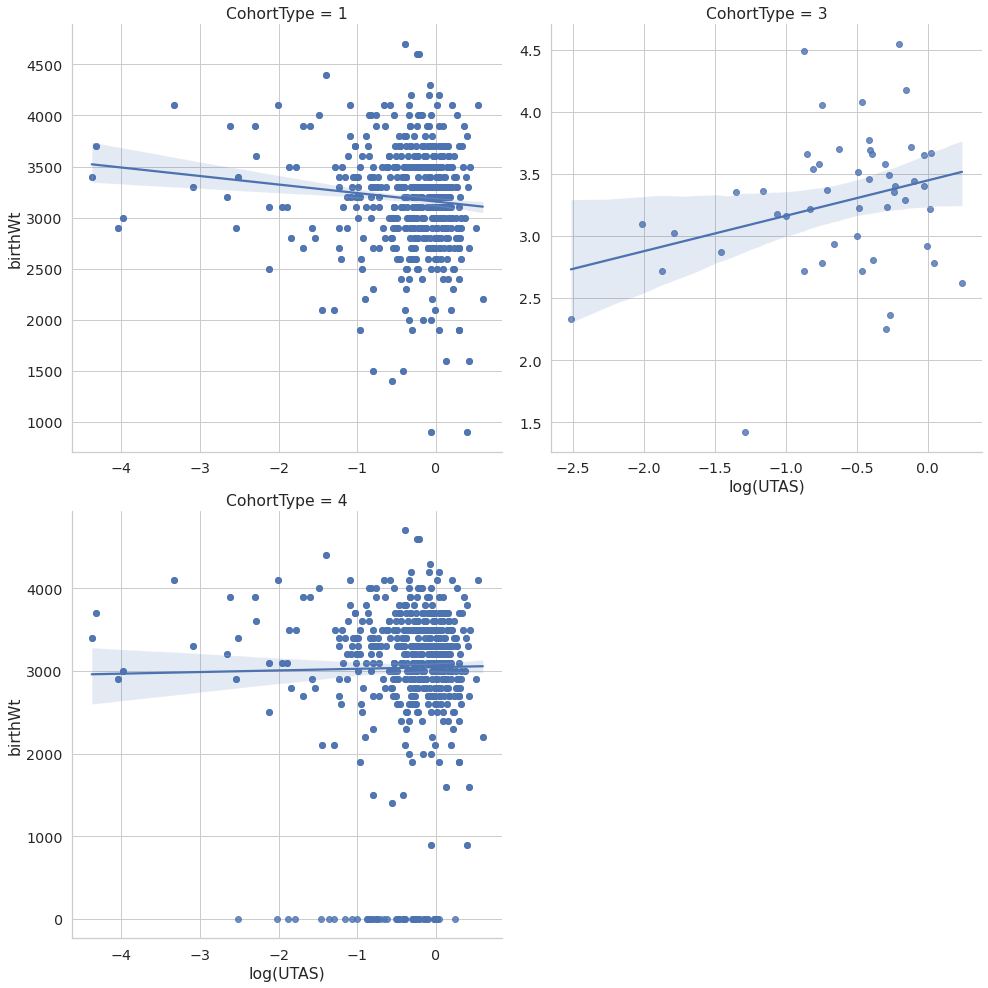

In [34]:
#data = fixvisits(data)


x_feature = 'log(UTAS)'
y_feature = 'birthWt'
data = df
color_by = 'CohortType'
sns.set(style = 'whitegrid', font_scale = 1.3)


filtered_df = data3

filtered_df = filtered_df[~filtered_df[x_feature].isna()]
filtered_df = filtered_df[~filtered_df[y_feature].isna()]



#take log transform
filtered_df[x_feature] = np.log(filtered_df[x_feature])
#data[x_feature] = np.log(data[x_feature])

color_by_options = filtered_df[color_by].unique()

reg_info0 = ''
reg_info1 = ''

gr = sns.lmplot(data=filtered_df, x=x_feature, 
                y=y_feature, col = color_by, sharey = False, sharex = False, col_wrap = 2,
                legend_out=False, 
                height=7, aspect=1,
                palette='binary')

#TODO fix legends - not the best way to display equations

labs = filtered_df['CohortType'].unique()
for x in labs:

    try:
        x2 = float(x)
    except:
        x2 = x
    labs2.append(x2)

print(labs)
# for x in xrange(len(color_by_options)):
# adding support if we want to color by multiple options 

num_lines = len(data3['CohortType'].unique())

reg_infos = ['Regression Equations:\n']

if (num_lines > 1):

    for i in range(0, num_lines):
        try:
            
            x = filtered_df.loc[filtered_df[color_by] == labs2[i], x_feature].values
            y = filtered_df.loc[filtered_df[color_by] == labs2[i], y_feature].values

            # this is problematic for calcuatign the true stats
            # = [gr.axes.flat[0].get_lines()[i].get_xdata()]
            #y = [gr.axes.flat[0].get_lines()[i].get_ydata()]

            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

            reg_info1 = 'Cohort ' + str(labs[i]) + ": y={:.2f}x + {:.2f} \n r^2={:.2f}, p={:.2f}, std_err={:.2f}\n".format(
            
            slope, intercept, r_value**2, p_value, std_err)
            
            print(reg_info1)

            reg_infos.append(reg_info1)

        except Exception as exc:
            print('Error: We need 2 points to create a line...')
            print(traceback.format_exc())
            print(exc)

#reg_info = "{}  |  {}".format(reg_info0, reg_info1)

#gr.fig.suptitle(' | '.join(reg_infos), 1, .98)

#plt.suptitle(''.join(reg_infos), **{'x': 1.4, 'y':.98})
#plt.legend(bbox_to_anchor=(.85, 0., 0.5, 0.5), title = color_by)

In [33]:
~filtered_df[x_feature].isna()

0      False
1       True
2       True
3       True
4       True
       ...  
565    False
566     True
567     True
568     True
569     True
Name: log(UTAS), Length: 2384, dtype: bool

In [22]:
x

array([        nan,  0.04376984, -0.26932827, -0.09905535, -0.80884221,
       -0.41520857, -0.82709674, -0.46619101, -1.2887508 , -0.4094975 ,
       -0.74571893, -0.0064741 , -0.15478408, -0.70908562, -0.39472927,
       -0.85188119, -0.02457396, -1.35246827,  0.24059806, -0.41172349,
       -0.11523624, -0.87252439, -0.74421184, -0.30443612,         nan,
       -0.65945394, -0.20582073, -0.50165432,         nan, -2.01566995,
       -0.46536178, -1.78579879,         nan,  0.01797976, -1.06243389,
       -0.49231087, -0.15718715, -1.45832951, -0.23130941, -0.48434061,
       -0.768106  ,         nan,  0.01942715, -0.03007784, -2.51435272,
               nan, -0.2758842 , -0.87175203, -0.38837089, -1.00199068,
       -1.16085862, -0.624469  , -0.28724964, -0.23838434, -1.87575773,
               nan,         nan, -0.29265034])

cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [ ]:
Report:
    
    